In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.applications import InceptionResNetV2

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data-ICIAR/Macenko/train/'
test_dir = "data-ICIAR/Macenko/test/"

extracted_features_dir = "extracted_features/"
model_name = "Macenko_InceptionResNetV2_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ICIAR/Macenko/train/ 0
data-ICIAR/Macenko/train/Benign 1155
data-ICIAR/Macenko/train/InSitu 1155
data-ICIAR/Macenko/train/Invasive 1155
data-ICIAR/Macenko/train/Normal 1155
******************************
data-ICIAR/Macenko/test/ 0
data-ICIAR/Macenko/test/Benign 25
data-ICIAR/Macenko/test/InSitu 25
data-ICIAR/Macenko/test/Invasive 25
data-ICIAR/Macenko/test/Normal 25


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152

predict_size_train: 109
predict_size_validation: 36
nb_test_samples: 100
predict_size_test: 4

 num_classes: 4


In [25]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [41]:
model = InceptionResNetV2(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [42]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_204
2 batch_normalization_204
3 activation_204
4 conv2d_205
5 batch_normalization_205
6 activation_205
7 conv2d_206
8 batch_normalization_206
9 activation_206
10 max_pooling2d_5
11 conv2d_207
12 batch_normalization_207
13 activation_207
14 conv2d_208
15 batch_normalization_208
16 activation_208
17 max_pooling2d_6
18 conv2d_212
19 batch_normalization_212
20 activation_212
21 conv2d_210
22 conv2d_213
23 batch_normalization_210
24 batch_normalization_213
25 activation_210
26 activation_213
27 average_pooling2d_2
28 conv2d_209
29 conv2d_211
30 conv2d_214
31 conv2d_215
32 batch_normalization_209
33 batch_normalization_211
34 batch_normalization_214
35 batch_normalization_215
36 activation_209
37 activation_211
38 activation_214
39 activation_215
40 mixed_5b
41 conv2d_219
42 batch_normalization_219
43 activation_219
44 conv2d_217
45 conv2d_220
46 batch_normalization_217
47 batch_normalization_220
48 activation_217
49 activation_220
50 conv2d_216
51 conv2d_218
52 conv2d_221

In [43]:
# print(model.layers[11].name)

In [44]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[18].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[275].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[618].output
c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[768].output
# c6 = GlobalAveragePooling2D()(c6) 

# con = concatenate([c1, c2, c3, c4, c5, c6]) %84
con = concatenate([c1, c2, c4, c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [45]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 255, 255, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 255, 255, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, 61, 61, 32)   96          conv2d_273[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 61, 61, 32)   0           batch_normalization_273[0][0]    
__________________________________________________________________________________________________
conv2d_271 (Conv2D)             (None, 61, 61, 32)   10240       block35_9_ac[0][0]               
__________________________________________________________________________________________________
conv2d_274 (Conv2D)             (None, 61, 61, 48)   13824       activation_273[0][0]             
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 61, 61, 32)   96          conv2d_271[0][0]                 
__________

In [46]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [47]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [48]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [49]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 5s - loss: 1.3766 - acc: 0.3613 - val_loss: 1.2031 - val_acc: 0.4809
Epoch 2/1000
 - 1s - loss: 1.2119 - acc: 0.4354 - val_loss: 1.1547 - val_acc: 0.4688
Epoch 3/1000
 - 1s - loss: 1.1468 - acc: 0.4761 - val_loss: 1.1260 - val_acc: 0.4688
Epoch 4/1000
 - 1s - loss: 1.0976 - acc: 0.5274 - val_loss: 1.0091 - val_acc: 0.6102
Epoch 5/1000
 - 1s - loss: 1.0501 - acc: 0.5487 - val_loss: 1.0021 - val_acc: 0.6120
Epoch 6/1000
 - 1s - loss: 1.0183 - acc: 0.5704 - val_loss: 0.9472 - val_acc: 0.6562
Epoch 7/1000
 - 1s - loss: 0.9668 - acc: 0.6003 - val_loss: 0.9106 - val_acc: 0.6719
Epoch 8/1000
 - 1s - loss: 0.9449 - acc: 0.6148 - val_loss: 0.8715 - val_acc: 0.6814
Epoch 9/1000
 - 1s - loss: 0.9109 - acc: 0.6335 - val_loss: 0.8576 - val_acc: 0.6727
Epoch 10/1000
 - 1s - loss: 0.8980 - acc: 0.6384 - val_loss: 0.8137 - val_acc: 0.7066
Epoch 11/1000
 - 1s - loss: 0.8618 - acc: 0.6612 - val_loss: 0.7856 - val_acc: 0.7205
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.2487 - acc: 0.9213 - val_loss: 0.2156 - val_acc: 0.9332
Epoch 97/1000
 - 1s - loss: 0.2474 - acc: 0.9221 - val_loss: 0.2035 - val_acc: 0.9392
Epoch 98/1000
 - 1s - loss: 0.2464 - acc: 0.9172 - val_loss: 0.2058 - val_acc: 0.9462
Epoch 99/1000
 - 1s - loss: 0.2421 - acc: 0.9224 - val_loss: 0.2038 - val_acc: 0.9401
Epoch 100/1000
 - 1s - loss: 0.2366 - acc: 0.9224 - val_loss: 0.2082 - val_acc: 0.9332
Epoch 101/1000
 - 1s - loss: 0.2388 - acc: 0.9250 - val_loss: 0.1924 - val_acc: 0.9418
Epoch 102/1000
 - 1s - loss: 0.2326 - acc: 0.9233 - val_loss: 0.2050 - val_acc: 0.9436
Epoch 103/1000
 - 1s - loss: 0.2356 - acc: 0.9196 - val_loss: 0.2708 - val_acc: 0.9019
Epoch 104/1000
 - 1s - loss: 0.2260 - acc: 0.9282 - val_loss: 0.1874 - val_acc: 0.9531
Epoch 105/1000
 - 1s - loss: 0.2300 - acc: 0.9233 - val_loss: 0.1922 - val_acc: 0.9462
Epoch 106/1000
 - 1s - loss: 0.2272 - acc: 0.9311 - val_loss: 0.2893 - val_acc: 0.8932
Epoch 107/1000
 - 1s - loss: 0.2281 - acc: 0.92

Epoch 191/1000
 - 1s - loss: 0.1257 - acc: 0.9648 - val_loss: 0.1006 - val_acc: 0.9766
Epoch 192/1000
 - 1s - loss: 0.1256 - acc: 0.9660 - val_loss: 0.0926 - val_acc: 0.9826
Epoch 193/1000
 - 1s - loss: 0.1218 - acc: 0.9686 - val_loss: 0.1066 - val_acc: 0.9722
Epoch 194/1000
 - 1s - loss: 0.1170 - acc: 0.9689 - val_loss: 0.0990 - val_acc: 0.9766
Epoch 195/1000
 - 1s - loss: 0.1153 - acc: 0.9700 - val_loss: 0.0866 - val_acc: 0.9774
Epoch 196/1000
 - 1s - loss: 0.1175 - acc: 0.9703 - val_loss: 0.0951 - val_acc: 0.9748
Epoch 197/1000
 - 1s - loss: 0.1157 - acc: 0.9691 - val_loss: 0.0919 - val_acc: 0.9800
Epoch 198/1000
 - 1s - loss: 0.1202 - acc: 0.9680 - val_loss: 0.0968 - val_acc: 0.9792
Epoch 199/1000
 - 1s - loss: 0.1109 - acc: 0.9680 - val_loss: 0.0875 - val_acc: 0.9826
Epoch 200/1000
 - 1s - loss: 0.1207 - acc: 0.9668 - val_loss: 0.0888 - val_acc: 0.9800
Epoch 201/1000
 - 1s - loss: 0.1153 - acc: 0.9697 - val_loss: 0.0844 - val_acc: 0.9809
Epoch 202/1000
 - 1s - loss: 0.1212 - acc: 

 - 1s - loss: 0.0771 - acc: 0.9801 - val_loss: 0.0557 - val_acc: 0.9887
Epoch 286/1000
 - 1s - loss: 0.0802 - acc: 0.9761 - val_loss: 0.0731 - val_acc: 0.9809
Epoch 287/1000
 - 1s - loss: 0.0780 - acc: 0.9810 - val_loss: 0.0726 - val_acc: 0.9792
Epoch 288/1000
 - 1s - loss: 0.0740 - acc: 0.9830 - val_loss: 0.0547 - val_acc: 0.9896
Epoch 289/1000
 - 1s - loss: 0.0819 - acc: 0.9781 - val_loss: 0.0556 - val_acc: 0.9887
Epoch 290/1000
 - 1s - loss: 0.0758 - acc: 0.9847 - val_loss: 0.0538 - val_acc: 0.9844
Epoch 291/1000
 - 1s - loss: 0.0767 - acc: 0.9815 - val_loss: 0.0547 - val_acc: 0.9861
Epoch 292/1000
 - 1s - loss: 0.0707 - acc: 0.9859 - val_loss: 0.0549 - val_acc: 0.9861
Epoch 293/1000
 - 1s - loss: 0.0757 - acc: 0.9815 - val_loss: 0.0614 - val_acc: 0.9826
Epoch 294/1000
 - 1s - loss: 0.0732 - acc: 0.9833 - val_loss: 0.0652 - val_acc: 0.9835
Epoch 295/1000
 - 1s - loss: 0.0663 - acc: 0.9853 - val_loss: 0.0676 - val_acc: 0.9766
Epoch 296/1000
 - 1s - loss: 0.0703 - acc: 0.9853 - val_lo

Epoch 380/1000
 - 1s - loss: 0.0551 - acc: 0.9888 - val_loss: 0.0408 - val_acc: 0.9887
Epoch 381/1000
 - 1s - loss: 0.0494 - acc: 0.9896 - val_loss: 0.0441 - val_acc: 0.9870
Epoch 382/1000
 - 1s - loss: 0.0561 - acc: 0.9870 - val_loss: 0.0472 - val_acc: 0.9887
Epoch 383/1000
 - 1s - loss: 0.0502 - acc: 0.9885 - val_loss: 0.0496 - val_acc: 0.9870
Epoch 384/1000
 - 1s - loss: 0.0578 - acc: 0.9864 - val_loss: 0.0530 - val_acc: 0.9861
Epoch 385/1000
 - 1s - loss: 0.0512 - acc: 0.9913 - val_loss: 0.0484 - val_acc: 0.9852
Epoch 386/1000
 - 1s - loss: 0.0528 - acc: 0.9911 - val_loss: 0.0459 - val_acc: 0.9861
Epoch 387/1000
 - 1s - loss: 0.0511 - acc: 0.9885 - val_loss: 0.0412 - val_acc: 0.9896
Epoch 388/1000
 - 1s - loss: 0.0517 - acc: 0.9893 - val_loss: 0.0415 - val_acc: 0.9913
Epoch 389/1000
 - 1s - loss: 0.0528 - acc: 0.9882 - val_loss: 0.0470 - val_acc: 0.9852
Epoch 390/1000
 - 1s - loss: 0.0527 - acc: 0.9905 - val_loss: 0.0435 - val_acc: 0.9878
Epoch 391/1000
 - 1s - loss: 0.0570 - acc: 

 - 1s - loss: 0.0459 - acc: 0.9882 - val_loss: 0.0351 - val_acc: 0.9887
Epoch 475/1000
 - 1s - loss: 0.0459 - acc: 0.9913 - val_loss: 0.0344 - val_acc: 0.9905
Epoch 476/1000
 - 1s - loss: 0.0413 - acc: 0.9925 - val_loss: 0.0303 - val_acc: 0.9922
Epoch 477/1000
 - 1s - loss: 0.0405 - acc: 0.9925 - val_loss: 0.0355 - val_acc: 0.9905
Epoch 478/1000
 - 1s - loss: 0.0422 - acc: 0.9908 - val_loss: 0.0299 - val_acc: 0.9922
Epoch 479/1000
 - 1s - loss: 0.0440 - acc: 0.9896 - val_loss: 0.0353 - val_acc: 0.9878
Epoch 480/1000
 - 1s - loss: 0.0391 - acc: 0.9925 - val_loss: 0.0302 - val_acc: 0.9913
Epoch 481/1000
 - 1s - loss: 0.0436 - acc: 0.9899 - val_loss: 0.0289 - val_acc: 0.9948
Epoch 482/1000
 - 1s - loss: 0.0406 - acc: 0.9919 - val_loss: 0.0311 - val_acc: 0.9939
Epoch 483/1000
 - 1s - loss: 0.0407 - acc: 0.9913 - val_loss: 0.0321 - val_acc: 0.9905
Epoch 484/1000
 - 1s - loss: 0.0437 - acc: 0.9896 - val_loss: 0.0305 - val_acc: 0.9922
Epoch 485/1000
 - 1s - loss: 0.0420 - acc: 0.9902 - val_lo

Epoch 569/1000
 - 1s - loss: 0.0341 - acc: 0.9925 - val_loss: 0.0266 - val_acc: 0.9939
Epoch 570/1000
 - 1s - loss: 0.0344 - acc: 0.9945 - val_loss: 0.0251 - val_acc: 0.9931
Epoch 571/1000
 - 1s - loss: 0.0329 - acc: 0.9948 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 572/1000
 - 1s - loss: 0.0350 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9939
Epoch 573/1000
 - 1s - loss: 0.0324 - acc: 0.9942 - val_loss: 0.0261 - val_acc: 0.9913
Epoch 574/1000
 - 1s - loss: 0.0308 - acc: 0.9937 - val_loss: 0.0251 - val_acc: 0.9905
Epoch 575/1000
 - 1s - loss: 0.0323 - acc: 0.9948 - val_loss: 0.0270 - val_acc: 0.9922
Epoch 576/1000
 - 1s - loss: 0.0374 - acc: 0.9911 - val_loss: 0.0308 - val_acc: 0.9905
Epoch 577/1000
 - 1s - loss: 0.0348 - acc: 0.9925 - val_loss: 0.0237 - val_acc: 0.9939
Epoch 578/1000
 - 1s - loss: 0.0349 - acc: 0.9925 - val_loss: 0.0280 - val_acc: 0.9931
Epoch 579/1000
 - 1s - loss: 0.0331 - acc: 0.9934 - val_loss: 0.0262 - val_acc: 0.9913
Epoch 580/1000
 - 1s - loss: 0.0314 - acc: 

 - 1s - loss: 0.0296 - acc: 0.9945 - val_loss: 0.0255 - val_acc: 0.9931
Epoch 664/1000
 - 1s - loss: 0.0265 - acc: 0.9965 - val_loss: 0.0238 - val_acc: 0.9931
Epoch 665/1000
 - 1s - loss: 0.0299 - acc: 0.9954 - val_loss: 0.0226 - val_acc: 0.9939
Epoch 666/1000
 - 1s - loss: 0.0293 - acc: 0.9939 - val_loss: 0.0219 - val_acc: 0.9948
Epoch 667/1000
 - 1s - loss: 0.0297 - acc: 0.9925 - val_loss: 0.0301 - val_acc: 0.9913
Epoch 668/1000
 - 1s - loss: 0.0278 - acc: 0.9954 - val_loss: 0.0296 - val_acc: 0.9905
Epoch 669/1000
 - 1s - loss: 0.0273 - acc: 0.9951 - val_loss: 0.0230 - val_acc: 0.9939
Epoch 670/1000
 - 1s - loss: 0.0265 - acc: 0.9957 - val_loss: 0.0240 - val_acc: 0.9913
Epoch 671/1000
 - 1s - loss: 0.0256 - acc: 0.9954 - val_loss: 0.0253 - val_acc: 0.9948
Epoch 672/1000
 - 1s - loss: 0.0245 - acc: 0.9963 - val_loss: 0.0243 - val_acc: 0.9922
Epoch 673/1000
 - 1s - loss: 0.0314 - acc: 0.9934 - val_loss: 0.0239 - val_acc: 0.9922
Epoch 674/1000
 - 1s - loss: 0.0288 - acc: 0.9954 - val_lo

Epoch 758/1000
 - 1s - loss: 0.0246 - acc: 0.9945 - val_loss: 0.0228 - val_acc: 0.9931
Epoch 759/1000
 - 1s - loss: 0.0264 - acc: 0.9951 - val_loss: 0.0204 - val_acc: 0.9965
Epoch 760/1000
 - 1s - loss: 0.0235 - acc: 0.9965 - val_loss: 0.0240 - val_acc: 0.9922
Epoch 761/1000
 - 1s - loss: 0.0245 - acc: 0.9954 - val_loss: 0.0192 - val_acc: 0.9965
Epoch 762/1000
 - 1s - loss: 0.0242 - acc: 0.9954 - val_loss: 0.0228 - val_acc: 0.9931
Epoch 763/1000
 - 1s - loss: 0.0286 - acc: 0.9925 - val_loss: 0.0184 - val_acc: 0.9965
Epoch 764/1000
 - 1s - loss: 0.0236 - acc: 0.9968 - val_loss: 0.0207 - val_acc: 0.9948
Epoch 765/1000
 - 1s - loss: 0.0226 - acc: 0.9971 - val_loss: 0.0256 - val_acc: 0.9905
Epoch 766/1000
 - 1s - loss: 0.0292 - acc: 0.9960 - val_loss: 0.0276 - val_acc: 0.9931
Epoch 767/1000
 - 1s - loss: 0.0234 - acc: 0.9965 - val_loss: 0.0208 - val_acc: 0.9957
Epoch 768/1000
 - 1s - loss: 0.0200 - acc: 0.9965 - val_loss: 0.0191 - val_acc: 0.9948
Epoch 769/1000
 - 1s - loss: 0.0231 - acc: 

 - 1s - loss: 0.0206 - acc: 0.9954 - val_loss: 0.0161 - val_acc: 0.9965
Epoch 853/1000
 - 1s - loss: 0.0220 - acc: 0.9960 - val_loss: 0.0294 - val_acc: 0.9896
Epoch 854/1000
 - 1s - loss: 0.0196 - acc: 0.9980 - val_loss: 0.0174 - val_acc: 0.9965
Epoch 855/1000
 - 1s - loss: 0.0196 - acc: 0.9977 - val_loss: 0.0183 - val_acc: 0.9948
Epoch 856/1000
 - 1s - loss: 0.0215 - acc: 0.9977 - val_loss: 0.0197 - val_acc: 0.9948
Epoch 857/1000
 - 1s - loss: 0.0201 - acc: 0.9963 - val_loss: 0.0238 - val_acc: 0.9931
Epoch 858/1000
 - 1s - loss: 0.0206 - acc: 0.9960 - val_loss: 0.0170 - val_acc: 0.9965
Epoch 859/1000
 - 1s - loss: 0.0184 - acc: 0.9977 - val_loss: 0.0211 - val_acc: 0.9931
Epoch 860/1000
 - 1s - loss: 0.0242 - acc: 0.9951 - val_loss: 0.0235 - val_acc: 0.9931
Epoch 861/1000
 - 1s - loss: 0.0223 - acc: 0.9954 - val_loss: 0.0191 - val_acc: 0.9939
Epoch 862/1000
 - 1s - loss: 0.0209 - acc: 0.9965 - val_loss: 0.0201 - val_acc: 0.9957
Epoch 863/1000
 - 1s - loss: 0.0224 - acc: 0.9963 - val_lo

Epoch 947/1000
 - 1s - loss: 0.0156 - acc: 0.9986 - val_loss: 0.0174 - val_acc: 0.9957
Epoch 948/1000
 - 1s - loss: 0.0188 - acc: 0.9960 - val_loss: 0.0152 - val_acc: 0.9957
Epoch 949/1000
 - 1s - loss: 0.0194 - acc: 0.9963 - val_loss: 0.0171 - val_acc: 0.9957
Epoch 950/1000
 - 1s - loss: 0.0189 - acc: 0.9965 - val_loss: 0.0145 - val_acc: 0.9974
Epoch 951/1000
 - 1s - loss: 0.0175 - acc: 0.9968 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 952/1000
 - 1s - loss: 0.0163 - acc: 0.9986 - val_loss: 0.0141 - val_acc: 0.9974
Epoch 953/1000
 - 1s - loss: 0.0200 - acc: 0.9971 - val_loss: 0.0161 - val_acc: 0.9957
Epoch 954/1000
 - 1s - loss: 0.0203 - acc: 0.9965 - val_loss: 0.0159 - val_acc: 0.9957
Epoch 955/1000
 - 1s - loss: 0.0184 - acc: 0.9971 - val_loss: 0.0148 - val_acc: 0.9974
Epoch 956/1000
 - 1s - loss: 0.0178 - acc: 0.9974 - val_loss: 0.0170 - val_acc: 0.9974
Epoch 957/1000
 - 1s - loss: 0.0182 - acc: 0.9965 - val_loss: 0.0154 - val_acc: 0.9983
Epoch 958/1000
 - 1s - loss: 0.0174 - acc: 

In [50]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9


Confusion Matrix
[[21  2  1  1]
 [ 1 24  0  0]
 [ 0  2 23  0]
 [ 1  1  1 22]]


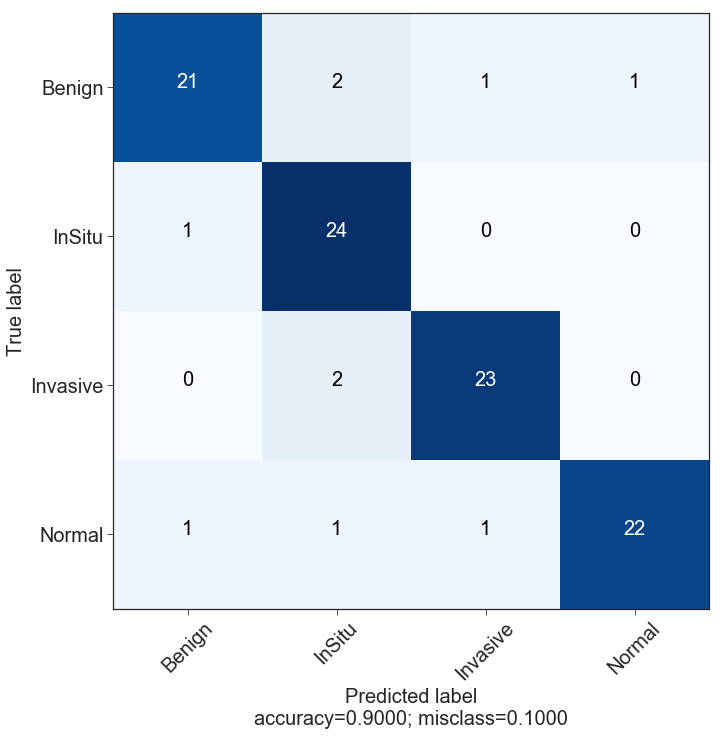

In [51]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [52]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  2  1  1]
 [ 1 24  0  0]
 [ 0  2 23  0]
 [ 1  1  1 22]]
              precision    recall  f1-score   support

      Normal       0.91      0.84      0.87        25
    Invasive       0.83      0.96      0.89        25
      Benign       0.92      0.92      0.92        25
      InSitu       0.96      0.88      0.92        25

   micro avg       0.90      0.90      0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [53]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.45454545454545
Specificity :  92.3076923076923


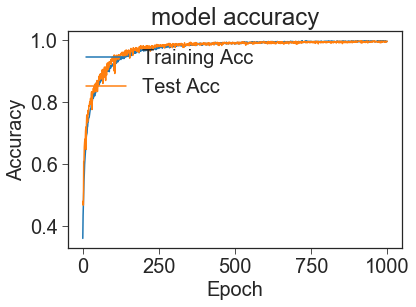

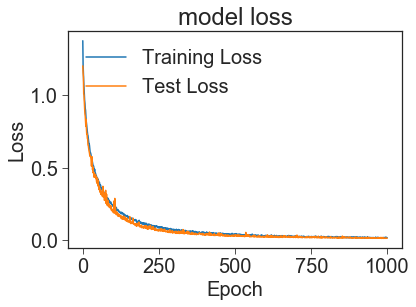

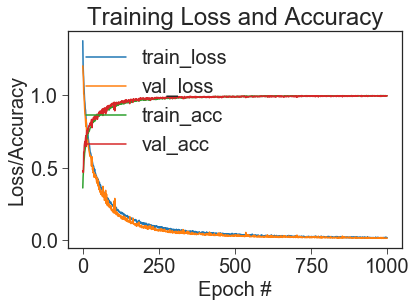

In [54]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")